# Perfectly matched Layer
The perfectly matched layer (PML) is the theoratical approach for the boundary in sumulating an open field. The "real" open field would not have any boundary. With the FDTD we need a boundary conditions to be able to do a simulation. The perfect boundary for the simluation would absorbe all incoming waves. The PML is an effective approach to simulate such an absorbing boundary.

### Historical Background: The Berenger´s split field formulation

The Berenger´s split field formulation is the simplest and most efficient approach in two dimensions. The reason for this is that, contrary to the (Uniaxial) UPML, we can avoid the storage requirements of electric and magnetic flux vectors and the additional complexity due to dealing with dispersive materials. It is important to note that this benefit accrues only in two dimensions.

Berenger recognized that an additional degree of freedom would permit a match off normal as well. He did this by splitting the transverse fields into two orthogonal components, for example $H_z = H_{zx} + H_{zy}$. Applying this to a two-dimensional TE problem described by the Maxwell-equations with lossless materials _(Eq: 3.5 - 3.7)_:

$$\frac{\partial E_x}{\partial t} = \frac{1}{\epsilon}\frac{\partial H_z}{\partial y}$$

$$\frac{\partial E_y}{\partial t} = -\frac{1}{\epsilon}\frac{\partial H_z}{\partial x}$$

$$\frac{\partial H_z}{\partial t} = \frac{1}{\mu} \biggl(\frac{\partial E_x}{\partial y} - \frac{\partial E_y}{\partial x} \biggl)$$

result in four equations:

$$\frac{\partial E_x}{\partial t} = \frac{1}{\epsilon} \frac{\partial (H_{zx} + H_{zy})}{\partial y}$$

$$\frac{\partial E_y}{\partial t} = -\frac{1}{\epsilon} \frac{\partial (H_{zx} + H_{zy})}{\partial x}$$

$$\frac{\partial H_{zx}}{\partial t} = -\frac{1}{\mu}\frac{\partial E_y}{\partial x}$$

$$\frac{\partial H_{zy}}{\partial t} = \frac{1}{\mu}\frac{\partial E_x}{\partial y}$$

## Simulation

The code allows to simulate different scenarios. The simulation region is defined by the the steps and the spatial distance of each step. In this region we can place a line source and a PEC cylinder. The choosen area will be plottet later on.

In [121]:
using GeometryBasics
using CairoMakie
using Plots

In [169]:
line_source = false;
cyl_present = true;
cube_present = false;

Beside the simulation area different physical constants need to be defined. 

In [170]:
#Physical constants
c = 2.997925e8;    # [m/s] Speed of light in vacuum
eps_0 = 8.854187817e-12; # [F/m] ϵ_0
mu_0 = 4*pi*1e-7;  # [H/m] μ_0
eta_0 = sqrt(mu_0/eps_0);

The simulation area has to be meshed. We choose for the rectengular area a mesh with 200 steps in each direction. 

In [221]:
#Simulation area
sizeX = 2      # [m] size of simulation region
sizeY = 1      # [m] size of simulation region
refinement = 200    # [cells/m] 
N_x = Int(refinement/sizeX)      # number of cells in x-direction
N_y = Int(refinement/sizeY)      # number of cells in y-direction
delta_s = sizeX/refinement       # [m] spatial step
M = 350           # Number of time steps
L = Int(round(N_x/2))    # scat/tot field boundary          
R = 1                                 # fraction of Courant limit. Must be <= 1
delta_t = R * delta_s/(c * sqrt(2))   # [s] Time step size

sigma = 5.0e-11      # Controls spectral content of Gaussian derivative pulse equals 1/omega_max
m_offset = 4*sigma;  # Controls switch-on time
Peak = 1;            # Peak amplitude of E field

# PEC cylinder position at x=0.75m y=0.5m.
radius = 0.03 # [m] radius of cylinder
N_centre_x = Int(round(0.75*N_x));
N_centre_y = Int(round(0.6*N_y));
# PEC Cube position at 
sides = 0.1  # [m] side length of cube
N_centre_x_cub = Int(round(0.75*N_x));
N_centre_y_cub = Int(round(0.3*N_y));

Setting up the material grid an the PML

In [222]:
# Set up material grid (free space to start)
sigma_x = zeros(N_x,N_y);
sigma_y = zeros(N_x,N_y);
sigma_ast_x = zeros(N_x,N_y);
sigma_ast_y = zeros(N_x,N_y);

In [223]:
# Set up PML
poly_m = 3
sigma_max = 0.8*(poly_m+1)/(eta_0*delta_s)
d_cell = 10
# For y-absorption.
for jj = 1:d_cell
    dist = d_cell-(jj-1)
    sigma_y[:,jj] .= sigma_max*(dist/d_cell)^poly_m
    sigma_y[:,N_y-jj+1] = sigma_y[:,jj]
end

for jj = 1:d_cell
    dist = d_cell-(jj-1)-0.5; # Hz field components located delta/2 away.
    sigma_ast_y[:,jj] .= eta_0^2*sigma_max*(dist/d_cell)^poly_m;
    sigma_ast_y[:,N_y-jj] = sigma_ast_y[:,jj];
end

# For x-absorption. Corner regions are automatically overlapped.
for ii = 1:d_cell
    dist = d_cell-(ii-1);
    sigma_x[ii,:] .= sigma_max*(dist/d_cell)^poly_m;
    sigma_x[N_x-ii+1,:] = sigma_x[ii,:];
end

for ii = 1:d_cell
    dist = d_cell-(ii-1)-0.5; # Hz field components located delta/2 away.
    sigma_ast_x[ii,:] .= eta_0^2*sigma_max*(dist/d_cell)^poly_m;
    sigma_ast_x[N_x-ii,:] = sigma_ast_x[ii,:];
end

The material constants are defined as:

### The FDTD update equations for a PML

With the theoretical background, associated with two components of $\sigma^*$ ($\sigma_x^*$ and $\sigma_y^*$) and two components of $\sigma$ ($\sigma_x$ and $\sigma_y$), describing the electrical ($\sigma$) and magnetic ($\sigma^*$) loss, the time domain equations are _(Eq.: 3.58 - 3.61)_:

$$ \biggl( \epsilon \frac{\partial}{\partial t}+\sigma_y \biggl) E_x = \frac{\partial(H_{zx}+H_{zy})}{\partial y}$$

$$ \biggl( \epsilon \frac{\partial}{\partial t}+\sigma_x \biggl) E_x = -\frac{\partial(H_{zx}+H_{zy})}{\partial x}$$

$$ \biggl( \mu \frac{\partial}{\partial t}+\sigma_x^* \biggl) H_zx = -\frac{\partial E_y}{\partial x}$$

$$ \biggl( \mu \frac{\partial}{\partial t}+\sigma_y^* \biggl) H_zy = \frac{\partial E_x}{\partial y}$$

To evaluate the electric field, we use the _semi-implicit_ approximation. It is needed, because of the problem of evaluating the electric field at a half time step. The required value is computed as the average of the previous (known) value and the as-yet-to-be-computed value:

$$E_x\biggl(i+\frac{1}{2},j,n+\frac{1}{2}\biggl)= \frac{E_x(i+\frac{1}{2},j,n+1)+E_x(i+\frac{1}{2},j,n)}{2}$$

Using this approximation, and otherwise proceeding as before, the result is the following set of update equations _(Eq.: 3.63 - 3.66)_:

$$H_{zx}(i,j,n)=D_{a_{Hzx}}(i,j)\cdot H_{zx}(i,j,n-1)-D_{b_{Hzx}}(i,j)\cdot [E_y(i+1,j,n) - E_y(i,j,n)]$$

$$H_{zy}(i,j,n)=D_{a_{Hzy}}(i,j)\cdot H_{zy}(i,j,n-1)-D_{b_{Hzy}}(i,j)\cdot [E_x(i,j+1,n) - E_x(i,j,n)]$$

$$E_x(i,j,n+1)=C_{a_{Ex}}(i,j)\cdot E_{x}(i,j,n)+C_{b_{Ex}}(i,j)\cdot [H_z(i,j,n) - H_z(i,j-1,n)]$$

$$E_y(i,j,n+1)=C_{a_{Ey}}(i,j)\cdot E_y(i,j,n)-C_{b_{Ey}}(i,j)\cdot [H_z(i,j,n) - H_z(i-1,j,n)]$$

, where we have combined the $H$ field _(Eq.:3.67)_:

$$H_z(i,j,n) = H_{zx}(i,j,n)+H_{zy}(i,j,n)$$

and the material constants as _(Eq.:3.68 - 3.75)_:

$$C_{a_{Ex}} (i,j) = \frac{1 - \frac{\sigma_y(i,j)\Delta t}{2\epsilon(i,j)}}{1+ \frac{\sigma_y(i,j)\Delta t}{2 \epsilon (i,j)}} \qquad \qquad \qquad 
C_{b_{Ex}} (i,j) = \frac{\frac{\Delta t}{\epsilon(i,j) \Delta y}}{1+ \frac{\sigma_y(i,j)\Delta t}{2 \epsilon (i,j)}}$$

$$C_{a_{Ey}} (i,j) = \frac{1 - \frac{\sigma_x(i,j)\Delta t}{2\epsilon(i,j)}}{1+ \frac{\sigma_x(i,j)\Delta t}{2 \epsilon (i,j)}} \qquad \qquad \qquad
C_{b_{Ey}} (i,j) = \frac{\frac{\Delta t}{\epsilon(i,j) \Delta x}}{1+ \frac{\sigma_x(i,j)\Delta t}{2 \epsilon (i,j)}}$$

$$D_{a_{Hzx}}(i,j) = \frac{1 - \frac{\sigma_x^*(i,j)\Delta t}{2\mu(i,j)}}{1+ \frac{\sigma_x^*(i,j)\Delta t}{2 \mu (i,j)}} \qquad \qquad \qquad
D_{b_{Hzx}} (i,j) = \frac{\frac{\Delta t}{\mu (i,j) \Delta x}}{1+ \frac{\sigma_x^*(i,j)\Delta t}{2 \mu (i,j)}}$$

$$D_{a_{Hzy}} (i,j) = \frac{1 - \frac{\sigma_y^*(i,j)\Delta t}{2\mu (i,j)}}{1+ \frac{\sigma_x^*(i,j)\Delta t}{2 \mu (i,j)}} \qquad \qquad \qquad
D_{b_{Hzy}} (i,j) = \frac{\frac{\Delta t}{\mu(i,j) \Delta y}}{1+ \frac{\sigma_y^*(i,j)\Delta t}{2 \mu (i,j)}}$$

In [224]:
C_aEx = (1 .- sigma_y * delta_t / (2*eps_0)) ./ (1 .+sigma_y*delta_t/(2*eps_0)); 
C_bEx = delta_t / (eps_0*delta_s) ./ (1 .+ sigma_y * delta_t / (2*eps_0));
C_aEy = (1 .-sigma_x*delta_t/(2*eps_0))./(1 .+sigma_x*delta_t/(2*eps_0)); 
C_bEy = delta_t/(eps_0*delta_s)./(1 .+sigma_x*delta_t/(2*eps_0));
D_aHzx = (1 .-sigma_ast_x*delta_t/(2*mu_0))./(1 .+sigma_ast_x*delta_t/(2*mu_0)); 
D_bHzx = delta_t/(mu_0*delta_s)./(1 .+sigma_ast_x*delta_t/(2*mu_0));
D_aHzy = (1 .-sigma_ast_y*delta_t/(2*mu_0))./(1 .+sigma_ast_y*delta_t/(2*mu_0)); 
D_bHzy = delta_t/(mu_0*delta_s)./(1 .+sigma_ast_y*delta_t/(2*mu_0));

if cyl_present # Otherwise just leave it as free space
    for ii = 1:N_x
        for jj = 1:N_y
            if (sqrt(((ii-1/2-(N_centre_x-1))*delta_s)^2 + ((jj-1-(N_centre_y-1))*delta_s)^2 ) <= radius) 
                C_bEx[ii,jj] = 0;
            end
            if (sqrt(((ii-1-(N_centre_x-1))*delta_s)^2 + ((jj-1/2-(N_centre_y-1))*delta_s)^2 ) <= radius) 
                C_bEy[ii,jj] = 0;
            end
        end
    end
end 

if cube_present # Otherwise just leave it as free space
    for x = N_centre_x_cub-Int(sides/(delta_s*2)):N_centre_x_cub+Int(sides/(delta_s*2))
        for y = N_centre_y_cub-Int(sides/(delta_s*2)):N_centre_y_cub+Int(sides/(delta_s*2)) 
            if y < N_centre_y_cub+Int(sides/(delta_s*2))
                C_bEy[x,y] = 0;
            end
            if x < N_centre_x_cub+Int(sides/(delta_s*2))
                C_bEx[x,y] = 0;
            end
        end
    end
end 

In [225]:
# Set up storage for time histories.
H_z_point1 = zeros(1,M)
E_y_point1 = zeros(1,M)
point1_x = Int(round(0.6*N_x))
point1_y = Int(round(N_y/2))

100

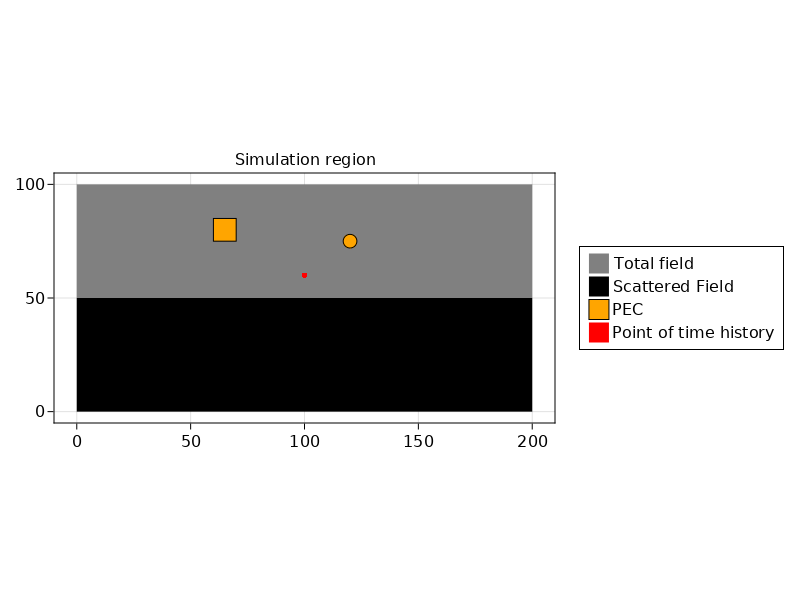

In [229]:
sim_region = Figure()
Axis(sim_region[1, 1], aspect = DataAspect(), title="Simulation region")
up_L=poly!(Rect(0,L,N_y,L), color = :grey)
un_L=poly!(Rect(0,0,N_y,L), color = :black)

if cyl_present
    Cyl =poly!(Circle(Point2f0(
        N_centre_y, N_centre_x),
        radius/delta_s),
        color = :orange,
        strokecolor = :black,
        strokewidth = 1
    )
end

if cube_present
    poly!(Rect(N_centre_y_cub,N_centre_x_cub,sides/delta_s,sides/delta_s), 
        color=:orange,
        strokecolor = :black,
        strokewidth = 1
    )
end

meas=poly!(Circle(Point2f0(point1_y, point1_x), 1), color = :red)
Legend(
    sim_region[1, 2],
    [up_L, un_L, Cyl, meas],
    ["Total field", "Scattered Field", "PEC", "Point of time history"]
)
sim_region

In [183]:
# First time step - Initialize values for H_z, E_x and E_y
H_zx_nmin1 = zeros(N_x,N_y); 
H_zy_nmin1 = zeros(N_x,N_y); 
E_x_nmin1 = zeros(N_x,N_y); 
E_y_nmin1 = zeros(N_x,N_y); 
# Pre-allocation
H_zx_n = zeros(N_x,N_y); 
H_zy_n = zeros(N_x,N_y); 
H_z_n = zeros(N_x,N_y); 
E_x_n = zeros(N_x,N_y); 
E_y_n = zeros(N_x,N_y);
E_y_ninc = zeros(N_y);
H_z_ninc = zeros(N_y);

A normalized Gaussian derivative pulse:
$$v_0(t) = - \frac{e^{1/2}}{\sigma}(t-m)e^{-(t-m)^2/2\sigma^2}$$
The normalizing constant $e^{1/2}/\sigma$ provides a unit peak amplitude at $t - m = ± \sigma$.

In [184]:
function gaussder_norm(t,m,sigma)
    y = -exp(0.5)*(t-m)/sigma*exp(-(t-m)^2/(2*sigma^2))
    return y
end

gaussder_norm (generic function with 1 method)

In [185]:
movieH = []
gauss = []
# Time loop
for m = 2:M   
    # Update H fields: 
    H_zx_n[1:N_x-1,1:N_y-1] = D_aHzx[1:N_x-1,1:N_y-1].*H_zx_nmin1[1:N_x-1,1:N_y-1] - 
        D_bHzx[1:N_x-1,1:N_y-1] .* (E_y_nmin1[2:N_x,1:N_y-1] - E_y_nmin1[1:N_x-1,1:N_y-1])
    H_zy_n[1:N_x-1,1:N_y-1] = D_aHzy[1:N_x-1,1:N_y-1].*H_zy_nmin1[1:N_x-1,1:N_y-1] + 
        D_bHzy[1:N_x-1,1:N_y-1] .* (E_x_nmin1[1:N_x-1,2:N_y] - E_x_nmin1[1:N_x-1,1:N_y-1])
    
    if line_source 
        # Drive a test line hard source - used to check basic operation
        H_z_n = H_zx_n+H_zy_n
        H_z_n[Int(N_x/2),Int(N_y/2)] = gaussder_norm((m-1)*delta_t,m_offset,sigma)
    else # Special update on scat/tot field boundary
        E_y_nmin1_inc = ones(1,N_y)*Peak*gaussder_norm((m-1)*delta_t - (L-1)*delta_s/c,m_offset,sigma)
        H_zx_n[L,1:N_y-1] += D_bHzx[L,1:N_y-1] .* E_y_nmin1_inc[1:N_y-1]
        H_z_n = H_zx_n+H_zy_n
    end
    # Update E fields: note that latest H fields must be used.
    E_x_n[2:N_x,2:N_y] = C_aEx[2:N_x,2:N_y] .* E_x_nmin1[2:N_x,2:N_y] + 
        C_bEx[2:N_x,2:N_y] .* (H_z_n[2:N_x,2:N_y] - H_z_n[2:N_x,1:N_y-1])
    E_y_n[2:N_x,2:N_y] = C_aEy[2:N_x,2:N_y] .* E_y_nmin1[2:N_x,2:N_y] - 
        C_bEy[2:N_x,2:N_y] .* (H_z_n[2:N_x,2:N_y] - H_z_n[1:N_x-1,2:N_y])

    if !line_source 
        # Special update on scat/tot field boundary (only needed for Ey)
        H_z_n_inc = ones(1,N_y)*(Peak/eta_0)*gaussder_norm((m-1/2)*delta_t - (L-1/2)*delta_s/c,m_offset,sigma)
        E_y_n[L,2:N_y] += C_bEy[L,2:N_y] .* H_z_n_inc[2:N_y]
        H_z_ninc = H_z_n_inc
    end
    
    # Fix outer values of E_tangential as PEC:
    E_y_n[1,:] .= 0
    E_y_n[N_x,:] .= 0
    E_x_n[:,1] .= 0
    E_x_n[:,N_y] .= 0

    # Movie
    push!(movieH, (eta_0 .* H_z_n))
    
    #Time history
    H_z_point1[m] = H_z_n[point1_x,point1_y]
    E_y_point1[m] = E_y_n[point1_x,point1_y]
    
    # Update for next iteration
    H_zx_nmin1 = H_zx_n
    H_zy_nmin1 = H_zy_n
    E_x_nmin1 = E_x_n
    E_y_nmin1 = E_y_n
end

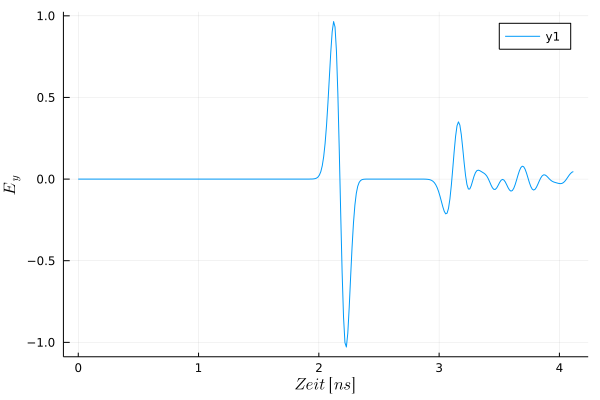

In [214]:
time=(range(0,M-1, step=1) |> collect)*delta_t
Plots.plot(time/1e-9,transpose(E_y_point1))
Plots.xlabel!(L"Zeit \ [ns]")
Plots.ylabel!(L"E_y")

┌ Info: Saved animation to 
│   fn = /Users/jacobthones/Documents/Universität/M. Sc 2. Semester/Simulation of EM fields /FDTD_PML/tmp.gif
└ @ Plots /Users/jacobthones/.julia/packages/Plots/snhSk/src/animation.jl:104


Plots.AnimatedGif("/Users/jacobthones/Documents/Universität/M. Sc 2. Semester/Simulation of EM fields /FDTD_PML/tmp.gif")
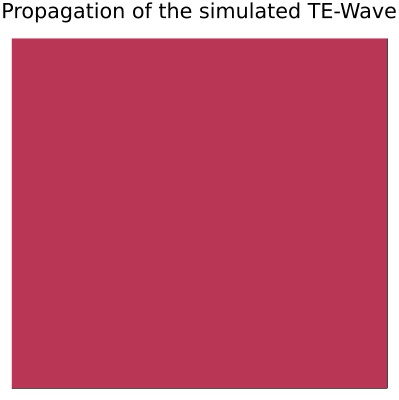

In [220]:
plotsizeX = 400*sizeX
plotsizeY = 400*sizeY
anim = @animate for i in 1:5:length(movieH)
    Plots.plot(
        [1:N_y],[1:N_x],
        movieH[i],
        st=:surface,
        camera=(0,90),
        zlim=(-1,1), 
        colorbar=false, 
        size=(plotsizeX, plotsizeY),
        axis=nothing
    )
    Plots.title!("Propagation of the simulated TE-Wave")
end
gif(anim, fps=10)